
# Portfolio-Exam | Visual Graffiti Detector for Hamburg Urban City | Tom Ruge

This notebook was developed using google Colab.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/your-username/your-repo-name/blob/main/your-notebook.ipynb)


## 0. Goal and Story
The following story is made up and **fully fictional**!  


I am working in the data science unit of the city Hamburg and will develop following experiment: In this project I will develop a software which detects graffiti based on pictures. The potentially successful graffiti detector will be applied to the surveillance cameras in Hamburg to automatically detect graffiti. So far, this has been done irregularly by several employees. This is expensive and organizational effort. In addition, the metric of how certain the model is about a detection is used to prioritize the cleanings. This means that graffiti can be combated more effectively. There are a number of positive effects, such as higher property prices and a better sense of well-being. The goal will be to develop a deep learning model which can do exactly that. The data was taken by me using my phone. I will go later more into detail about the data. The project is therefore a binary classification between graffiti and no graffiti.

## Task 1 - The Data
To train and evaluate a model it is necessary to have data. I took 883 pictures in Kiel within of approx. 4 hours.

| Category              | Number of Pictures | Percentage |
|-----------------------|--------------------|------------|
| Graffiti Pictures      | 452                | 53.9%      |
| Non-Graffiti Pictures  | 386               | 46.1%      |
| **Total**              | **838**            | **100%**   |


The pictures were taken with the same IPhone and are of JPEG format. The data is saved with following scheme:

```
data/
├── IsGraffiti/
│   ├── image1.JPEG
│   ├── image2.JPEG
│   └── ...
└── IsNotGraffiti/
    ├── image1.JPEG
    ├── image2.JPEG
    └── ...
```
This data is suited for training a classifier to distiguish between graffiti andn non graffiti pictures. In the following notebook we will see whether enough pictures were taken and whether the pictures are too diverss or not diverse enough. I took the pictures with the intention to make them diverse in order to also battle hard pictures to classify.
### 1.1 Preparation
I will at first import the used packages, connect to google drive and load the data.

In [1]:
# System and File Handling
import os
import sys
import gc

# Data Manipulation
import pandas as pd
import numpy as np

# Image Processing
import cv2
from PIL import Image

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC


# PyTorch and Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.transforms import functional as F
from torchvision.models import resnet18, ResNet18_Weights

# TensorBoard for Visualization
from torch.utils.tensorboard import SummaryWriter

# Progress Bar
from tqdm import tqdm


Connect to google drive and specify file path. If you want to run the code locally, comment the following code block out.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

data_direc = '/content/drive/MyDrive/data/DL_Capstone'

Mounted at /content/drive


Specify path for outputted results:

In [3]:
output_dir = 'results/'
os.makedirs(output_dir, exist_ok=True)

I will load the data using opencv. For that I wrote a python function which makes reading in the data comfortable. I will read in the data with reduced size. Otherwise the pictures will take up around 9GB of ram, which my laptop can not handle.

In [4]:
# Function to load images, their labels, and file names
def load_images(data_dir, size_reduction=1):
    images = []
    labels = []
    file_names = []  # List to store file names
    class_names = ['IsGraffiti', 'IsNotGraffiti']  # names of the directories
    for label in class_names:
        folder_path = os.path.join(data_dir, label)
        for image_file in os.listdir(folder_path):
            img_path = os.path.join(folder_path, image_file)
            img = cv2.imread(img_path) # bilinear interpolation by default
            img = cv2.resize(img, (int(img.shape[1] // size_reduction), int(img.shape[0] // size_reduction)), interpolation=cv2.INTER_LINEAR)
            if img is not None:
                images.append(img)
                labels.append(label)
                file_names.append(image_file)  # Store the file name

    # make labels binary
    labels = [1 if label == 'IsGraffiti' else 0 for label in labels]
    return images, np.array(labels), np.array(file_names)

# Load images, labels, and file names
size_reduction = 2
images, labels, file_names = load_images(data_direc, size_reduction)

## Task 2 - IDA

In [5]:
print(f'Number of images: {len(images)}')

Number of images: 838


As already mentioned, the dataset consists of 883 pictures. We will display now a few sample pictures in order to investigate the diversity and complexity of the taken pictures.

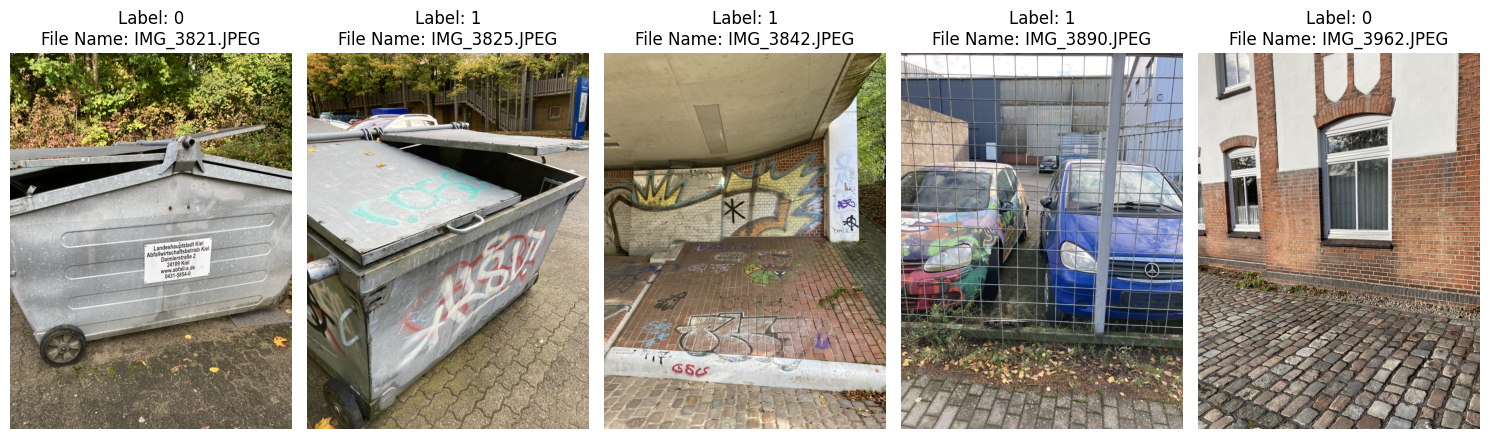

In [6]:
def get_specific_image(images, labels, file_names ,file_name2dis = []):
  mask = np.array([1 if elem in file_name2dis else 0 for elem in file_names]).astype(bool)
  images = [images[i] for i in range(len(images)) if mask[i] == 1]
  labels = labels[mask]
  file_names = file_names[mask]
  return images, labels, file_names

def show_sample_images(images, labels, file_names ,file_name2dis = []):
  # mask for images to display
  images, labels, file_names = get_specific_image(images, labels, file_names, file_name2dis)
  # reorder images, labels and file_names with ascending order of the file_names
  file_names, images, labels = zip(*sorted(zip(file_names, images, labels)))
  # create figure
  fig, axes = plt.subplots(1, len(images), figsize=(15, 15))
  for i, (image, label, file_name) in enumerate(zip(images, labels, file_names)):
      axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      axes[i].set_title(f"Label: {label}\nFile Name: {file_name}")
      axes[i].axis('off')
  plt.tight_layout()
  plt.show()

file_name2dis = ['IMG_3842.JPEG', 'IMG_3825.JPEG','IMG_3890.JPEG', 'IMG_3821.JPEG', 'IMG_3962.JPEG', ]
show_sample_images(images, labels, file_names, file_name2dis)

It can be seen that the pictures are very diverse ranging from sprayed vehicles to hole walls being filled with paint. In some cases the graffitis are dominant on the picture in other they aren't. The graffitis are in these cases only on small fractions of the picture. By graphical inspection graffitis have round edges and seem to be more colorfull then the background they are on. These investigations are important for builduing and testing models. The distribution of the two classes is already known from the introduction. Now we will investigate the shapes of the pictures.

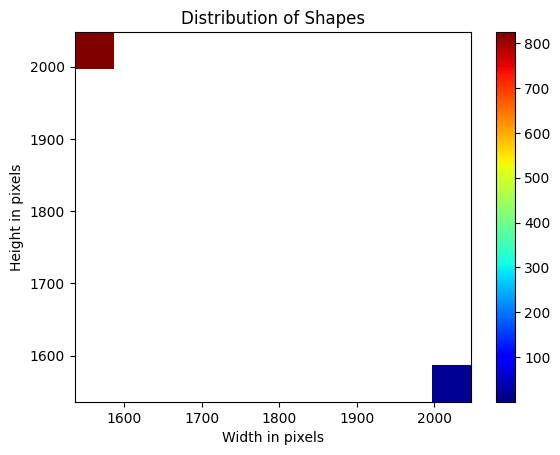

,height,width,label,count
0,1536,2048,0.0,6
1,1536,2048,1.0,7
2,2048,1536,0.0,380
3,2048,1536,1.0,445


In [7]:
def plot_shapes(images, file_names, labels, size_reduction):
  shapes = pd.DataFrame(columns=['file_name', 'height', 'width'])
  for image, file_name, label in zip(images, file_names, labels):
    height, width, _ = image.shape
    height = int(height * size_reduction)
    width = int(width *size_reduction)
    shapes = pd.concat([shapes, pd.DataFrame({'file_name': [file_name], 'height': [height], 'width': [width], 'label': [label]})], ignore_index=True)

  # create a 2d histogramm of the shapes, x axis width, y axis height.
  cmap = plt.get_cmap('jet')
  cmap.set_under('w')
  plt.hist2d(shapes['width'], shapes['height'],  cmap=cmap, vmin = 0.1)
  plt.colorbar()
  plt.xlabel('Width in pixels')
  plt.ylabel('Height in pixels')
  plt.title('Distribution of Shapes')
  plt.show()

  # display exxcat shapes
  display(shapes.groupby(['height', 'width', 'label']).size().reset_index(name='count'))

plot_shapes(images, file_names, labels, size_reduction)



It can be seen that most pictures were taken vertically. Only a few were taken horizontal. The horizontal pictures are not biased due to class imbalance, since te class distribution is approx. similiar. I will not flip the images since it is reasonable to assume that graffiti drawing are often independent of the exact orientation. This was we also introduce variability to the model.

## Task 3 - Preprocessing
No Preprocessing will be done here. The later used ResNet-18 model will
1. Resize to 256 x 256
2. Center crop to 224 pixels
3. Normalize pictures with mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225] (Standartscaler)

I will also implement an extra augmentation pipeline in order to rotate the input pictures to indroduce more variabilty and data. The preprocessing will be done using the ResNet-18 preprocessing. I will not normalize the counts for the EDA since it is just a scaling and does not quantitavely change the logic when apllying the deep learning model. It is just scaling.

In [8]:
def tensor_to_image(tensor):
    img = tensor.permute(1, 2, 0).numpy()  # Convert from CHW to HWC format
    img = (img * 255).astype(np.uint8)     # Scale back to 0-255 and convert to uint8
    img = img[:, :, [2, 1, 0]]  # Reorder channels from BGR to RGB
    return img


def load_preprocessed_images(data_dir, batch_size=32):
    # Custom preprocessing pipeline: resize, crop, normalize
    preprocess_transform = transforms.Compose([
        transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(224),  # Center crop to 224x224
        transforms.ToTensor()
        ])

    # Define a custom dataset class to include file names
    class ImageFolderWithFilenames(datasets.ImageFolder):
        def __getitem__(self, index):
            original_tuple = super(ImageFolderWithFilenames, self).__getitem__(index)
            path, _ = self.samples[index]
            filename = os.path.basename(path)
            return original_tuple + (filename,)

    # Initialize dataset with custom preprocessing transform
    dataset = ImageFolderWithFilenames(data_dir, transform=preprocess_transform)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    images = []
    labels = []
    file_names = []

    # Iterate over the DataLoader to retrieve images, labels, and file names
    for batch_images, batch_labels, batch_filenames in data_loader:
        images.extend(batch_images)
        labels.extend(batch_labels)
        file_names.extend(batch_filenames)

    # Convert lists to desired output format
    images = torch.stack(images)  # Stack images into a single tensor
    labels = torch.tensor(labels).numpy()  # Convert labels to numpy array
    file_names = np.array(file_names)

    # transform images to the apprpriate format for the next plotting fucntions
    images = [tensor_to_image(image) for image in images]
    labels = np.array([1 if label == 0 else 0 for label in labels]) # make 1 a graffiti.
    return images, labels, file_names

images_prepro, labels_prepro, file_names_prepro = load_preprocessed_images(data_direc)


How much of the pictures is cut away?

In [9]:
images_size_compare = ['IMG_4009.JPEG', 'IMG_4017.JPEG', 'IMG_4020.JPEG', 'IMG_4037.JPEG']
show_sample_images(images_prepro, np.array(labels_prepro), file_names_prepro, images_size_compare)
show_sample_images(images, labels, file_names, images_size_compare)


Output hidden; open in https://colab.research.google.com to view.

It can be seen that mostly the height of the pictures is cut away. I selected only pictures where the graffiti is somewhat central of picture height on the picture visible. I also tried to include pictures where the graffitis are on the edge of the picture in order to prevent the deep learning algorithm for only looking in the middle of the pictures.

## Task 4 - EDA
The pictures are complex and it is not easy to use simple exploratory data analysis to quantitavely display certain aspects and differences of the classes. I will investigate and emphasize certain aspects of the content of the pictures itself.

### 4.1 Same Background for Graffiti and non Graffiti
When I took pictures of the graffitis I tried to make also pictures from a similiar background in order to fight overfitting. I will display some examples below.


In [10]:
def plot_pairs(images, labels, file_names, file_name2dis = []):
    images, labels, file_names = get_specific_image(images, labels, file_names, file_name2dis)
    fig, axes = plt.subplots(1, len(images), figsize=(10, 10))
    for i, (image, label, file_name) in enumerate(zip(images, labels, file_names)):
        axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[i].set_title(f"Is Graffiti: {label}\nFile Name: {file_name}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

image_pairs = [('IMG_3825.JPEG', 'IMG_3821.JPEG'),
               ('IMG_3828.JPEG', 'IMG_3830.JPEG'),
               ('IMG_3904.JPEG', 'IMG_3905.JPEG')]
[plot_pairs(images_prepro, labels_prepro, file_names_prepro, pair) for pair in image_pairs]

Output hidden; open in https://colab.research.google.com to view.

The idea why is to make the model not to classify the background instead of the actual graffitis. But this was not done for all graffitis.

### 4.2 More Data Through Different Angles
I took multiple pictures of the same graffitis in order to increase the number of pictures with graffiti.

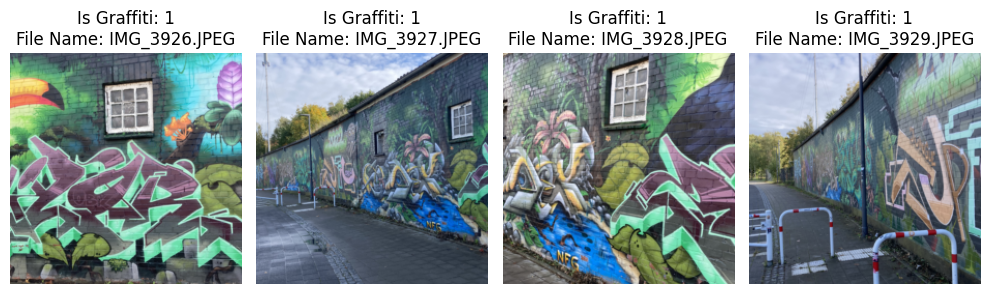

In [11]:
images_diff_angles = ['IMG_3926.JPEG', 'IMG_3927.JPEG', 'IMG_3928.JPEG', 'IMG_3929.JPEG']

plot_pairs(images_prepro, labels_prepro, file_names_prepro, images_diff_angles)

As it can be seen the diversity of those pictures seems high, since pictures were taken often from very different angles. Also the background changes. In those cases of graffiti it was not possible to take pictures of the same background without graffiti. When evaluating this model this should be considered. Due to time efforts I did not group those graffitis.

### 4.3 RGB Distribution
Graffitis might contain a different color spectrum than non graffiti pictures. In the next plot we will investigate the color spectrum by plotting the average freqeuencys of the rgp

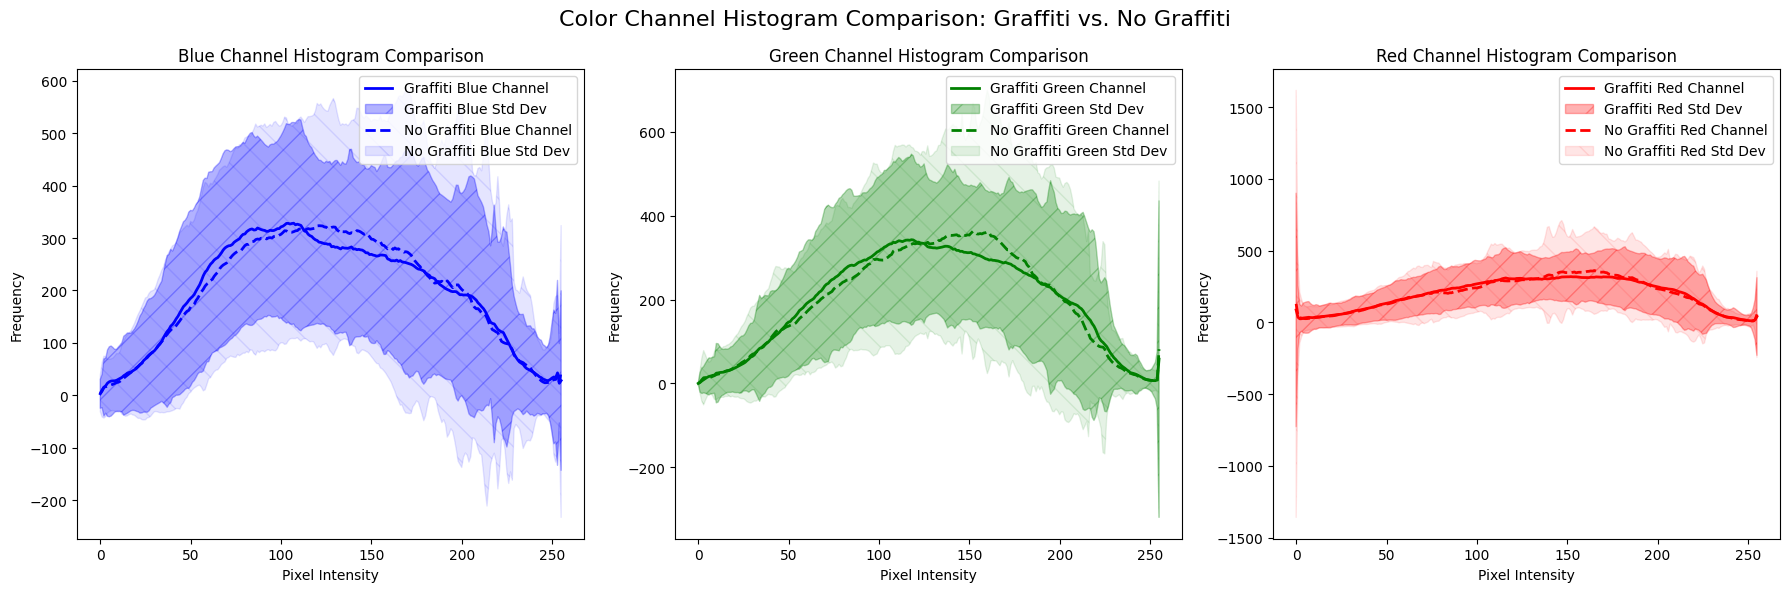

In [12]:
def plot_color_hist_comparison(images, labels, file_names):
    # Initialize lists to store histograms for each label
    blue_hist_list_graffiti = []
    green_hist_list_graffiti = []
    red_hist_list_graffiti = []

    blue_hist_list_no_graffiti = []
    green_hist_list_no_graffiti = []
    red_hist_list_no_graffiti = []

    # Calculate histograms for each image and separate by label
    for img, label in zip(images, labels):
        blue_hist = cv2.calcHist([img], [0], None, [256], [0, 256])
        green_hist = cv2.calcHist([img], [1], None, [256], [0, 256])
        red_hist = cv2.calcHist([img], [2], None, [256], [0, 256])

        if label == 1:
            blue_hist_list_graffiti.append(blue_hist)
            green_hist_list_graffiti.append(green_hist)
            red_hist_list_graffiti.append(red_hist)
        else:  # label == 'IsNotGraffiti'
            blue_hist_list_no_graffiti.append(blue_hist)
            green_hist_list_no_graffiti.append(green_hist)
            red_hist_list_no_graffiti.append(red_hist)

    # Function to calculate average and standard deviation for histograms
    def calculate_avg_std(hist_list):
        hist_array = np.array(hist_list)
        hist_avg = np.mean(hist_array, axis=0)
        hist_std = np.std(hist_array, axis=0)
        return hist_avg, hist_std

    # Calculate average and standard deviation for graffiti
    blue_avg_graffiti, blue_std_graffiti = calculate_avg_std(blue_hist_list_graffiti)
    green_avg_graffiti, green_std_graffiti = calculate_avg_std(green_hist_list_graffiti)
    red_avg_graffiti, red_std_graffiti = calculate_avg_std(red_hist_list_graffiti)

    # Calculate average and standard deviation for no graffiti
    blue_avg_no_graffiti, blue_std_no_graffiti = calculate_avg_std(blue_hist_list_no_graffiti)
    green_avg_no_graffiti, green_std_no_graffiti = calculate_avg_std(green_hist_list_no_graffiti)
    red_avg_no_graffiti, red_std_no_graffiti = calculate_avg_std(red_hist_list_no_graffiti)

    # Plotting the histograms for each color channel comparison
    color_channels = [
        ('Blue', blue_avg_graffiti, blue_std_graffiti, blue_avg_no_graffiti, blue_std_no_graffiti, 'b'),
        ('Green', green_avg_graffiti, green_std_graffiti, green_avg_no_graffiti, green_std_no_graffiti, 'g'),
        ('Red', red_avg_graffiti, red_std_graffiti, red_avg_no_graffiti, red_std_no_graffiti, 'r')
    ]

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for ax, (color, avg_graffiti, std_graffiti, avg_no_graffiti, std_no_graffiti, col) in zip(axes, color_channels):
        # Plot Graffiti data
        ax.plot(avg_graffiti, color=col, label=f'Graffiti {color} Channel', linewidth=2)
        ax.fill_between(
            range(256),
            (avg_graffiti - std_graffiti).flatten(),
            (avg_graffiti + std_graffiti).flatten(),
            color=col, alpha=0.3, label=f'Graffiti {color} Std Dev', hatch='/'
        )

        # Plot No Graffiti data
        ax.plot(avg_no_graffiti, color=col, linestyle='--', label=f'No Graffiti {color} Channel', linewidth=2)
        ax.fill_between(
            range(256),
            (avg_no_graffiti - std_no_graffiti).flatten(),
            (avg_no_graffiti + std_no_graffiti).flatten(),
            color=col, alpha=0.1, label=f'No Graffiti {color} Std Dev', hatch='\\'
        )

        # Plot settings for each subplot
        ax.set_xlabel('Pixel Intensity')
        ax.set_ylabel('Frequency')
        ax.set_title(f'{color} Channel Histogram Comparison')
        ax.legend(loc='upper right')

    # Adjust layout
    plt.tight_layout()
    plt.suptitle('Color Channel Histogram Comparison: Graffiti vs. No Graffiti', fontsize=16)
    plt.subplots_adjust(top=0.88)
    plt.show()

# Example usage
plot_color_hist_comparison(images_prepro, labels_prepro, file_names_prepro)


It can be seen that for all color changes no significant difference are existent between graffiti and non graffiti pictures. But it is noticable that the standart deviations for non graffiti pictures seems to slightly bigger. That indicates that no graffiti pictures may be more diverse. It is also noticable that the frequency is for low and high pixel intensitys peaking. This is due to oversaturation and undersaturation of the individual pixels. They assign higher or lower 'real intensitys' into the next higher or lower bin at the edges. In the next step we will investigate how the appearance of the pictures change if the number of pixels is reduced.

## Task 5 - Baselines
As a comparison for the upcoming tasks, compute two baselines:
### 5.1 Pick two evaluation metrics to evaluate the final model and explain your choice

The dataset is slightly unbalanced. There are approx. 6% more graffiti pictures then non graffiti pictures. This is why class distribution undependent scores should be used. This approach is better then making the dataset unbalanced because no data is wasted. Both graffiti and no graffiti classes have same importance.

#### AUC (Area Under the Curve)

- **Definition**: AUC is a metric that quantifies the overall performance of a binary classification model by measuring the area under the Receiver Operating Characteristic (ROC) curve. The ROC curve plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings.

- **Mathematical Representation**:
  $$
  \text{TPR} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}} \quad \text{(Sensitivity)}
  $$
  $$
  \text{FPR} = \frac{\text{False Positives}}{\text{False Positives} + \text{True Negatives}} \quad \text{(1 - Specificity)}
  $$

- **Interpretation**:
  - An AUC of **1** indicates a perfect classifier.
  - An AUC of **0.5** indicates a model that is no better than random guessing.
  - An AUC below **0.5** indicates that the classifier is more likely to predict the wrong class.

#### Balanced Accuracy

- **Definition**: Balanced accuracy is an average of the recall obtained on each class, taking into account the class distribution. It is particularly useful for evaluating models on imbalanced datasets.

- **Mathematical Representation**:
  $$
  \text{Balanced Accuracy} = \frac{1}{2} \left( \frac{\text{TP}}{\text{TP} + \text{FN}} + \frac{\text{TN}}{\text{TN} + \text{FP}} \right)
  $$
  where:
  - **TP** = True Positives
  - **TN** = True Negatives
  - **FP** = False Positives
  - **FN** = False Negatives

- **Interpretation**:
  - Balanced accuracy accounts for class imbalance by calculating the average of sensitivity and specificity.
  - It represents a fixed threshold at **0.5** in the ROC curve.
  - While balanced accuracy provides insight into model performance at a specific threshold, AUC evaluates performance across various thresholds.

#### Comparison

- The AUC and balanced accuracy are closely related, but they serve different purposes:
  - **AUC** provides a comprehensive measure of performance across all classification thresholds.
  - **Balanced accuracy** gives a snapshot of model performance at a specific threshold.
  - When comparing models, AUC is generally more appropriate, as it evaluates performance more holistically across thresholds.


### 5.2 Use a very simple suitable heuristic (not a trained model) as a baseline.
Pictures are complex and I could not come up with a not trained model, which could do that better then random guessing. I will use a dummy classifier which performs random guessing.

In [13]:
results = pd.DataFrame()

def add_classification_eval(results, algorithm, y_train, y_train_pred, y_test, y_test_pred, num_params):
  '''
  Create a table with evaluation results of a classification algorithm.
  The predictions need to have probabilities for the positive class. Otherwise the AUC can not be evaluated.
  '''
  for dataset, actual, predicted in zip(('train', 'test'), (y_train, y_test), (y_train_pred, y_test_pred)):
    results = pd.concat([results, pd.DataFrame({
      'Algorithm': [algorithm],
      'Dataset': [dataset],
      'Balanced Accuracy': [balanced_accuracy_score(actual,(predicted >= 0.5).astype(int))],
      'AUC': [roc_auc_score(actual,predicted)],
      'Trainable Params': [num_params]
    })], ignore_index=True)
  return results

def results_nice(results):
  train = results[results['Dataset'] == 'train'].sort_values('AUC', ascending=False)
  test = results[results['Dataset'] == 'test'].sort_values('AUC', ascending=False)
  display(train)
  display(test)

In [14]:
def dummy_classifier(X_train, y_train, X_test, y_test):
  dummy = DummyClassifier(strategy='uniform')
  dummy.fit(X_train, y_train)
  y_train_pred = dummy.predict_proba(X_train)[:, 1]
  y_test_pred = dummy.predict_proba(X_test)[:, 1]
  return y_train_pred, y_test_pred

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
y_train_pred, y_test_pred = dummy_classifier(X_train, y_train, X_test, y_test)

results = add_classification_eval(results, 'Dummy Classifier', y_train, y_train_pred, y_test, y_test_pred, 0)
results_nice(results)

,Algorithm,Dataset,Balanced Accuracy,AUC,Trainable Params
0,Dummy Classifier,train,0.5,0.5,0


,Algorithm,Dataset,Balanced Accuracy,AUC,Trainable Params
1,Dummy Classifier,test,0.5,0.5,0


### 5.3 Run and Evaluate One Classical ML Algorithm
The pictures are of high dimensional data and therefore I choose a Support Vector Machine as a second base line.  Compared to many other classical machine learning algorithms SVM can handle high dimensional data better than others. I will use a cross validation and fit the dataset multiple times, so we get an idea of the variation of the performance of the classifier. The data is very high dimensional and therefore I will first reduce the dimensions of the data to 224x224 pixels(Same as ResNet-18). To further reduce the number of dimensions I will convert the color coded picture to grayscale. We will also perform a train test split. Since the pictures are very complex and the amount of data is rather low it is not expected for the svm to yield usable results.

In [15]:
def scale_image(image, size=224):
    return cv2.resize(image, (size, size), interpolation=cv2.INTER_LINEAR)

def normalize_image(image):
    return image / 255.0

def to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

images_svm = [normalize_image(to_grayscale(scale_image(image))) for image in images]
X_train, X_test, y_train, y_test = train_test_split(images_svm, labels, test_size=0.2, random_state=42)
print(np.shape(X_train))

(670, 224, 224)


In [16]:
def train_svm(X_train, y_train, X_test, y_test):
    rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)
    model = SVC(probability=True, class_weight='balanced')
    model.fit(X_train, y_train)
    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_test_pred = model.predict_proba(X_test)[:, 1]
    return y_train_pred, y_test_pred

results = add_classification_eval(results, 'SVM', y_train, y_train_pred, y_test, y_test_pred, 2)
results_nice(results)

,Algorithm,Dataset,Balanced Accuracy,AUC,Trainable Params
0,Dummy Classifier,train,0.5,0.5,0
2,SVM,train,0.5,0.5,2


,Algorithm,Dataset,Balanced Accuracy,AUC,Trainable Params
1,Dummy Classifier,test,0.5,0.5,0
3,SVM,test,0.5,0.5,2


The Support Vector machine was not able to classify, whether the pictures contained graffitis or not. It performed equally good as the dummy uniform random classifier. Pictures are mostly too complex for classical machine learning algorithms to work with. This is where Neural Netowrks shine. They can handle due do way more parameters way more complex data.

## Task 6 - Deep Learning Experiments

### Description of Approach
The data is already in a good shape and no further preprocessing needs to be done. The goal in this chapter is to select, implement and explain exactly one architecture of a deep learning model. In this deep learning experiment I will do following steps.

I already have the data, which we need to get in shape four our neural network. I will when discussing about the model into detail about data preprocessing. The available dataset is relatively small and the pictures we want to classify are complex. The task is a image classifcation task and therefore it makes sense to finetune a image classification model for my application of a graffiti detection. There are a big number of different pretrained models available, like ResNet, EfficientNet, DenseNet and many more. In this exam it is the task to choose one model in advance and fine tuning using dropout layers. I will use ResNet-18 since it has shown its for many vision tasks good results. I will remove the last layer of the model and concatenate 3 more layers to the ResNet-18 architecture and will only fine tune those layers. The idea is to keep all the other paramaters of the other layers constant since they already have learned important features like edges, shapes etc... I will go later more into detail about my exact implementation of the neural network. Since the dataset is unbalanced, it is necessary to make the training data balanced. Otherwise the deep leanring model would learn how many percent of the pictures are graffiti and non graffiti. To do that I will implement a data augmentation pipeline in order to upsample the non graffiti pictures since the are the minority class. In that model we will optimize only optimize one probability parameter p for the implement droput layer. Afterwards we will decide based on the results, how to dial the dropout layer. When training the model I will not perform a nested cross validation, since this notebook only serves the porpouse of a proof of concept. For each investigation of the p parameter of the dropout layer I will split the dataset into 1 training, one tetsing and one validation set. The first split to get the validation set is done only ones to prevent information leaking thorugh the optimization process. The second split is then done randomly creates then the training and testing split for the optimization process. After choosiing an appropriate p parameter for the dropout I will perform a training based on the former now combined training and test set and the prediction of the just mentioned untouched validation set. This investigation will **not** give a good approximate for the later application, since for this poupose the same camera is used, no people are visible on the  pictures etc....



#### ResNet-18 Model Architecture Summary
Compared to datasets like ImageNet with 14 million pictures the dataset with 900 pictures is quite small. This is why I will use ResNet-18 model and fine tune it for the graffiti detection. Benefits of using this approach compared to completely training a model are that this model has already a complex and well trained featrue extraction. Especially the early layers of resnet are usefull or that. This approach will also reduce training time. At first we will import the model, load the the pretrained parameters and investigate the model.
The **ResNet-18** model is a deep convolutional neural network (CNN) based on the ResNet (Residual Networks) architecture. It consists of multiple layers such as convolutional layers, batch normalization, ReLU activations, pooling layers, and fully connected layers.

---

##### 1. Data Input and Initial Layers
When using transfer learning it is necessary to normalize the new pictures so the pictures are similiar and comparable to the ones the training was done with. The Resnet-18 model is expected to input normalized:
he images are resized to resize_size=[256] using interpolation=InterpolationMode., followed by a central crop of crop_size=[224]. Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]. The firts layer is a convolutional layer to start by extracting important features and then it is followed by a batch normalization. The goal of a batch normalization is to stabilize the model, by fighting gradient explosions. Also the [speed of training is increased](https://en.wikipedia.org/wiki/Batch_normalization). Then ReLu is used as activation function and MaxPooling is performed to reduce the number of dimensions.
##### Middle Layers - Basic Blocks
In ResNet-18, the essential building blocks are basic residual blocks. These blocks are fundamental to the ResNet architecture and enable it to achieve deeper layers without succumbing to issues like the vanishing gradient problem. They are structured like this:
```
BasicBlock(
    (conv1): Conv2d(...),
    (bn1): BatchNorm2d(...),
    (relu): ReLU(...),
    (conv2): Conv2d(...),
    (bn2): BatchNorm2d(...),
    (downsample): Sequential(...) # Optional, only for some blocks
)
```

The BasicBlock in ResNet receives an input tensor, usually an image or feature map. It has two main convolution layers. The first layer applies a 3x3 convolution with padding (usually 1 pixel) to maintain the output size and a stride of 1. This is followed by Batch Normalization and a ReLU activation function. The second layer also applies a 3x3 convolution with Batch Normalization.

There is a skip connection where the original input is preserved. If the input and output dimensions differ, a 1x1 convolution is applied to the input to match the output size. The output of the second convolution is then added to the original input, creating a residual connection. Finally, a ReLU activation function is applied to the result of the addition.

In summary, a BasicBlock consists of two convolutional layers with Batch Normalization and ReLU activations, a skip connection that adds the original input back to the output, and an optional downsampling method to match dimensions when necessary. The BasicBlock helps mitigate the vanishing gradient problem, improve training efficiency by allowing the network to learn residual functions, and preserve important features from earlier layers.

#### Final Layers
The first of the final layers is a Adaptive Pooling layer, which serves as a reduction of the dimensionality. The final layer is a linear layer having 2048 input features and 1000 output features, which are the classes. This layer we defintely want to remove and replace.

#### My model


##### 1. Pre-trained Architecture

- **Transfer Learning**: The model is based on ResNet-18, a well-established convolutional neural network (CNN) architecture that has been pre-trained on the ImageNet dataset. This extensive training involves **1.2 million images** across **1,000 classes**, providing the model with robust feature representations that can be transferred to new classification tasks, such as graffiti recognition.

- **Feature Extraction**: ResNet-18 is adept at learning hierarchical features from images, ranging from simple edges and textures to complex patterns. This characteristic is essential for capturing the diverse and intricate details that define various styles of graffiti.

- **Transfer Learning with Fine-tuning**: Initially freezing the layers of the pre-trained ResNet-18 allows me to leverage the learned features without modifying them. The **18 layers** of the ResNet-18 architecture are set to `requires_grad=False`, meaning their weights will not be updated during training. This approach is particularly useful when labeled data is scarce, as it enables the model to focus on learning the new classification task with only the final layers.

##### 2. Output Layer
- **Non-linear Activations**: The use of `LeakyReLU` activations introduces non-linearity into the model. This activation function helps the model to learn complex mappings between inputs (images) and outputs (class labels).


- **Overfitting Prevention**: The implememntations of drop out layers serve to mitigate overfitting, especially in situations where the dataset may be limited. This is also the case for out own data. This means that during training, some percent of the neurons are randomly "dropped out" in each forward pass, which encourages the model to learn robust features that are less reliant on any single neuron.

- **Count of Trainable Parameters**: The model's architecture features a total of **1,478,113 trainable parameters** (as indicated by the `count_params` method). This relatively low number of trainable parameters is advantageous for avoiding overfitting while still maintaining sufficient capacity to learn complex features from graffiti images.

  - The dense layers after the ResNet backbone are:
    - **128 neurons** in the first fully connected layer.
    - **Dropout** layer for regularization to decrease overfitting.
    - **ReLU** to make the final classifier layer not linear and make the model more complex.
    - **1 neuron** in the output layer (for binary classification). This will output a logit.


##### Data Augmentation

The available dataset is rather small and therefore I will use image augmentation to artificcialy increase the size of the dataset. I will use the RandomPerpective and RandomRotation methode from the transforms class in pytorch.

**Random Perpective:**

![pers](https://pytorch.org/vision/main/_images/sphx_glr_plot_transforms_illustrations_005.png)



**Random Rotation:**

![rot](https://pytorch.org/vision/main/_images/sphx_glr_plot_transforms_illustrations_006.png)

**How much augmentation:**

We will only slightly augment the pictures in order to not increase the difficulty for the model too much. We will randomly rotate the pictures by +-10°. The distortion factor i will also keep low for the same reasons. I will make use 2 times of this augmentation. Since the dataset is unbalanced I will oversample the minority class by using this augmentation techniques. Before passing it to the model we will apply this augmenation pipeline again.

---

Initially, we will set random seeds to ensure our experiment is as reproducible as possible. However, certain system-specific implementations can complicate this process, making it challenging to achieve complete reproducibility. In cases where specific random seeds cannot be set, it may not be necessary to enforce them, as randomness inherently introduces variability. Ultimately, no matter how rigorously we define other parameters, the application of a random transformation will always introduce some degree of unpredictability.

In [17]:
import random
# set random seed
RANDOM_SEED = 123
os.environ["PL_GLOBAL_SEED"] = str(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # run on gpu if possible

### Model Defintion
The architecture of the model already have been discussed in a previous chapter.

In [18]:
class ModifiedResNet18(nn.Module):
    def __init__(self, num_classes=1, dropout=0.5):
        super(ModifiedResNet18, self).__init__()
        # Load the pre-trained ResNet-18 model
        weights = ResNet18_Weights.DEFAULT
        self.preprocess_transform = weights.transforms()
        self.resnet = resnet18(weights=weights)
        number_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()

        # Freeze all layers from the pretrained model
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Replace the classifier with our own
        self.resnet.fc = nn.Sequential(
            nn.Linear(number_features, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        x = self.resnet(x)  # Forward through ResNet-18 model
        return x

    def count_params(self):
        '''
        Return the number of trainable parameters of a PyTorch Module (model).
        Iterate each of the module's parameters and count them
        if they require grad (if they are trainable).
        '''
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

# Example usage
model = ModifiedResNet18()
print("Number of trainable parameters:", model.count_params())
print(model)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 182MB/s]


Number of trainable parameters: 65793
ModifiedResNet18(
  (preprocess_transform): ImageClassification(
      crop_size=[224]
      resize_size=[256]
      mean=[0.485, 0.456, 0.406]
      std=[0.229, 0.224, 0.225]
      interpolation=InterpolationMode.BILINEAR
  )
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, mo

The used model has now approx. 66000 trainable parameter. The Resnet-18 model has approx. 12 million parameters. So we are training only 0.5% of the model.

---
I will perfrom upsampling using the ealrier mentioned augmentation pipeline:

In [19]:
def upsample_minority_class(images, labels, aug_pipe):
    lens = (len(labels[labels == 0]), len(labels[labels == 1]))
    minority_class = 0 if lens[0] < lens[1] else 1
    difference = lens[1] - lens[0] if minority_class == 0 else lens[0] - lens[1]
    minority_indices = (labels == minority_class).nonzero(as_tuple=True)[0]

    random_indices = minority_indices[torch.randint(len(minority_indices), (difference,), dtype=torch.long)]

    for index in random_indices:
        image = images[index]
        image = aug_pipe(image)
        images = torch.cat((images, image.unsqueeze(0)))
        labels = torch.cat((labels, torch.tensor([minority_class], device=labels.device)))
    return images, labels

The next chunk of code implements the training and evaluation procedure of the model. We will again use the same pipeline to augment the pictures and increase the diversity of the pictures to prevent overfitting of the complex model. We will save the results of the model in order not to rerun the long code execution every time we accidentaly delete the output. Do not get confused by the threshholding functionality I implemented. I used this to investigate the threshholds for the classification. I remained at a default threshhold at 0.5.

In [20]:
def train_model(model, train_loader, test_loader, criterion, optimizer, device, aug_pipe, optim_threshh):
    model.train()
    total_loss = 0
    y_true = []
    y_pred = []

    for images, labels in train_loader:
        images, labels = upsample_minority_class(images=images, labels=labels, aug_pipe=aug_pipe)
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(torch.sigmoid(outputs).detach().cpu().numpy())

    model.eval()
    loss_train, bal_acc_train, auc_score_train, threshhold_best_train = evaluate_model(model, train_loader, criterion, device, optim_threshh)
    loss_test, bal_acc_test, auc_score_test, threshhold_best_test = evaluate_model(model, test_loader, criterion, device, optim_threshh)

    return loss_train, bal_acc_train, auc_score_train, threshhold_best_train, loss_test, bal_acc_test, auc_score_test, threshhold_best_test

def evaluate_model(model, val_loader, criterion, device, optim_threshh):
    total_loss = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels.float())
            total_loss += loss.item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(torch.sigmoid(outputs).detach().cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    # iterate over all threshholds
    thressholds = np.sort(np.unique(y_pred))
    bal_acc_best = 0
    threshhold_best = 0.5
    if optim_threshh:
      for threshhold in thressholds:
          # calculate balanced accuracy
          bal_acc = balanced_accuracy_score(y_true, (y_pred > threshhold).astype(int))
          if bal_acc > bal_acc_best:
              bal_acc_best = bal_acc
              threshhold_best = threshhold

    bal_acc = balanced_accuracy_score(y_true, (y_pred > threshhold_best).astype(int))
    auc_score = roc_auc_score(y_true, y_pred)
    return total_loss / len(val_loader), bal_acc, auc_score, threshhold_best

def results_df():
    return pd.DataFrame(columns=['Iteration', 'Epoch',
                                 'Train Threshh','Train Loss', 'Train Balanced Accuracy', 'Train AUC',
                                 'Test Threshh','Test Loss', 'Test Balanced Accuracy', 'Test AUC'])

def model_fit(data_direc, criterion=nn.BCEWithLogitsLoss(),
              epochs=1, drop_outs=[0.5], patience=5, learning_rate = 0.001,
              batch_size = 64, final_training = False, optim_threshh = False, device = 'cpu', output_dir = 'results/'):
    model = ModifiedResNet18()
    dataset = datasets.ImageFolder(data_direc, transform=model.preprocess_transform)

    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])

    if not final_training:
      train_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [0.8, 0.2])

    results = results_df()

    if final_training:
      writer = SummaryWriter(output_dir +'/tensorboard/model_fit_experiment')

    # Total iterations for progress bar: dropouts * epochs
    total_iterations = len(drop_outs) * epochs

    # Single progress bar for both dropouts and epochs
    with tqdm(total=total_iterations, desc="Training Progress") as pbar:
        for drop_out in drop_outs:
            best_val_loss = float('inf')
            epochs_since_improvement = 0
            for epoch in range(epochs):
                model = ModifiedResNet18(dropout=drop_out)
                model.to(device)
                optimizer = optim.Adam(model.parameters(), lr=learning_rate)
                train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=6, pin_memory=True, persistent_workers=True, drop_last = True, prefetch_factor=4)
                test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=6, pin_memory=True, persistent_workers=True, drop_last = True, prefetch_factor=4)

                augmentation_pipeline = transforms.Compose([
                    transforms.RandomRotation(degrees=(-20,20)),
                    transforms.RandomPerspective(distortion_scale=0.2, p=0.2)
                ])

                train_loss, train_bal_acc, train_auc, threshhold_best_train,test_loss, test_bal_acc, test_auc, threshhold_best_test = train_model(
                    model=model,
                    train_loader=train_loader,
                    test_loader=test_loader,
                    criterion=criterion,
                    optimizer=optimizer,
                    device=device,
                    aug_pipe=augmentation_pipeline,
                    optim_threshh = optim_threshh
                )
                if final_training:
                  # Log metrics to TensorBoard
                  writer.add_scalar('Loss/train', train_loss, epoch)
                  writer.add_scalar('Loss/test', test_loss, epoch)
                  writer.add_scalar('Balanced Accuracy/train', train_bal_acc, epoch)
                  writer.add_scalar('Balanced Accuracy/test', test_bal_acc, epoch)
                  writer.add_scalar('AUC/train', train_auc, epoch)
                  writer.add_scalar('AUC/test', test_auc, epoch)

                if results.empty:
                    results = pd.DataFrame({
                        'Drop_Out': [drop_out],
                        'Epoch': [epoch],
                        'Train Threshh': [threshhold_best_train],
                        'Train Loss': [train_loss],
                        'Train Balanced Accuracy': [train_bal_acc],
                        'Train AUC': [train_auc],
                        'Test Threshh': [threshhold_best_test],
                        'Test Loss': [test_loss],
                        'Test Balanced Accuracy': [test_bal_acc],
                        'Test AUC': [test_auc]
                    })
                else:
                    results = pd.concat([results, pd.DataFrame({
                        'Drop_Out': [drop_out],
                        'Epoch': [epoch],
                        'Train Threshh': [threshhold_best_train],
                        'Train Loss': [train_loss],
                        'Train Balanced Accuracy': [train_bal_acc],
                        'Train AUC': [train_auc],
                        'Test Threshh': [threshhold_best_test],
                        'Test Loss': [test_loss],
                        'Test Balanced Accuracy': [test_bal_acc],
                        'Test AUC': [test_auc]
                    })], ignore_index=True)


                # Early stopping logic
                if test_loss < best_val_loss:
                    best_val_loss = test_loss
                    epochs_since_improvement = 0
                else:
                    epochs_since_improvement += 1


                if epochs_since_improvement >= patience:
                    pbar.update(epochs - epoch + 1)
                    print(f"Early stopping activated. Stopped after {epoch + 1} epochs.")
                    if final_training:
                      # save model
                      torch.save(model.state_dict(), output_dir + 'model.pth')
                      # close TensorBoard writer
                      writer.close()
                    break

                pbar.update(1)

    if final_training:
      # save model
      torch.save(model.state_dict(), output_dir + 'model.pth')
      # close TensorBoard writer
      writer.close()

    return results, train_loader, test_loader, model


Run the model with different dropout and use patience fo early stopping to save resources.

In [ ]:
drop_outs = [0, 0.2, 0.4, 0.6, 0.8]

result_m, train_loader, test_loader, model = model_fit(data_direc, epochs=50, patience = 10, learning_rate=0.001, batch_size = 64, drop_outs=drop_outs, optim_threshh = False, device = device, output_dir = output_dir)

# save results to csv
result_m.to_csv(output_dir + 'model_results.csv', index=False)

Training Progress:  11%|█         | 28/250 [08:03<1:03:49, 17.25s/it]

The following function provides the basis to decide what dropout layer to use.

In [ ]:
def plot_results(results_dir):
    # Load the results data
    results = pd.read_csv(results_dir)

    # Define the metrics to plot
    metrics = ['Loss', 'Balanced Accuracy', 'AUC']
    dropout_values = np.unique(results['Drop_Out'])

    # Set up the figure and subplots
    fig, ax = plt.subplots(len(dropout_values), len(metrics), figsize=(16, 5 * len(dropout_values)), constrained_layout=True)

    # Ensure 'ax' is a 2D array for e dropout value cases
    if len(dropout_values) == 1:
        ax = np.expand_dims(ax, axis=0)

    # Define colors and line styles for clarity
    train_color, test_color = '#1f77b4', '#ff7f0e'  # Blue and orange
    line_styles = ['-', '--']  # Solid for train, dashed for test

    # Iterate over each subplot
    # Loop through each dropout value and each metric
    for i, drop_out in enumerate(dropout_values):
        threshhold_train = results['Train Threshh'][i]
        threshhold_test = results['Test Threshh'][i]
        dropout_results = results[results['Drop_Out'] == drop_out]
        for j, metric in enumerate(metrics):
            # Plot training and testing metrics with custom styles
            ax[i, j].plot(dropout_results['Epoch'], dropout_results[f'Train {metric}'],
                          label=f'Train {metric}', color=train_color, linestyle=line_styles[0], linewidth=2)
            ax[i, j].plot(dropout_results['Epoch'], dropout_results[f'Test {metric}'],
                          label=f'Test {metric}', color=test_color, linestyle=line_styles[1], linewidth=2)

            # Add titles, labels, and grid
            ax[i, j].set_title(f'Dropout Rate: {drop_out} - {metric}\nThresh_Train: {threshhold_train}, Thresh_Test: {threshhold_test}', fontsize=14, fontweight='bold')
            ax[i, j].set_xlabel('Epoch', fontsize=12)
            ax[i, j].set_ylabel(metric, fontsize=12)
            ax[i, j].grid(True, linestyle=':', color='grey', alpha=0.6)

            # Optional y-axis limit to keep 'Loss' metric consistent across subplots
            if metric == 'Loss':
                ax[i, j].set_ylim(0, max(dropout_results[f'Train {metric}'].max(), dropout_results[f'Test {metric}'].max()) * 1.1)

            # Add a legend with a slightly transparent background
            legend = ax[i, j].legend(loc='best', fontsize=10)
            legend.get_frame().set_alpha(0.8)

    # Main title for the entire figure
    fig.suptitle("Training and Testing Metrics Across Epochs for Different Dropout Rates", fontsize=16, fontweight='bold', y=1.02)

    # Show the plot
    plt.show()



plot_results(output_dir + 'model_results.csv')

All scores and loss metrics are constant over time and no trend towars different scores is recognizable

**Loss**:
  
  - The test loss is always higher then the train loss. This is due to overfitting. The models memorizes the train data, which leads to a better loss for the train data but could lead to a higher loss for the train data. The loss increases with higher dropouts for both datasets. But less overfitting is apparent, because the curves move more close together. This is due to the dropout which is supposed to decrease overfitting. Both curve progression stay approx. constant over time and no significant improvement in learning is done.

**Balanced Accuracy**:

  - Both balanced accuracy scores a fluctuating quite strong over the course of the epochs and remain constant over time. The training is unstable and no improvement in balanced accuracy is done. The balanced accuracy for the train data is always higher then the test data. Again overfitting is visible. By eye it is not apparent that the fluctuation changes between different dropouts. Best balanced accuracy in average are visible for a 0 dropout. Both train and test balanced accruacy decreases with higher dropouts and the curves are moving more closely together. What is interesting is that the model is able to not randomly classify graffiti and no graffiti. For a dropout of 0 the balanced accuracy is in average approx. 0.76, which is not bad.
**AUC**:
  - The AUC score is for all curves constant and no improvement of the score is done. The train auc is always higher then the auf for the test dataset. Overfitting is apparent. The mentioned characteristics are shared between all metrics. The AUC score is at 0.83 for a dropout of 0 and 0.2 and then declines with higher dropouts.
**Summary**:

All metrics indicate that no learning was done over the course of the epochs. But the model is able to classify between graffiti and no graffiti with a balanced accuracy of approx. 0.76 for the training data and a dropout of 0. The scores are also fluctuating strong and the learning is very unstable. This suboptimal performance could have multiple reasons:

- Data to diverse.
- Too less parameters are newly trained on the data. Only 0.5%.
- Hyperparameters are not tweeked yet.
- Not enough data.


**What Dropout**:
The model is not able to learn more relevant features over the course of the epochs and the best auc score for both train and test set is done with a dropout of 0. The model is very unstable. Therefore adding more noise by using dropout layers makes learning even more unstable. This is why I will choose a droput of 0.

### Evaluate the final model using a tensorboard with one fit.
The Tensorboard is usefull for machine learning experiments. It can be used for...

  - Tracking and visualizing metrics such as loss and accuracy
  - Visualizing the model graph (ops and layers)
  - Viewing histograms of weights, biases, or other tensors as they change over time
  - Projecting embeddings to a lower dimensional space
  - Displaying images, text, and audio data
  - Profiling TensorFlow programs
  - And much more

At first I will load the jupyter tensorboard extension and then load the tensorboard for a specific directory. The tensorboard is loaded in advance, so live tracking of the model can be done.  


In [ ]:
%load_ext tensorboard
%tensorboard --logdir=results/runs/model_fit_experiment
%reload_ext tensorboard

Here I will start running the experiment. I will reuse my already used code from the previous dropout optimization. I will use a patience of 5 for early stopping, in order to be closer to the not overfitting area.

In [ ]:
drop_outs = [0]
results_m, train_loader, test_loader, model = model_fit(data_direc, epochs=50, patience = 5, learning_rate=0.001, batch_size = 64, drop_outs=drop_outs, final_training=True, ouput_dir = output_dir)

# plot results
plot_results(output_dir + 'model_results_final.csv')

It can be seen, that the model stopped already after a few epochs because the train loss could not be reduced within a epoch window of 10. This problem already has been discussed. But it can be seen that the balanced accuracy could haven been increased compared to the previous runs. No overfitting is visible. All scores were slightly improved. I will go into detail later. This is probably because that more data is used for training now compared to the hyperparametertuning. The next function gets the prediction of the validation set.

In [ ]:
def get_predictions(model, test_loader, train_loader, device = 'cpu'):
    model.to(device)
    model.eval()
    with torch.no_grad():
        train_images = []
        train_predictions = []
        train_true_labels = []
        test_images = []
        test_predictions = []
        test_true_labels = []
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze()
            train_images.extend(images.detach().cpu().numpy())
            train_predictions.extend(torch.sigmoid(outputs).detach().cpu().numpy())
            train_true_labels.extend(labels.cpu().numpy())
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze()
            test_images.extend(images.detach().cpu().numpy())
            test_predictions.extend(torch.sigmoid(outputs).detach().cpu().numpy())
            test_true_labels.extend(labels.cpu().numpy())
    return np.array(train_predictions), np.array(train_true_labels), np.array(test_predictions), np.array(test_true_labels), np.array(train_images), np.array(test_images)


train_predictions, train_true_labels, test_predictions, test_true_labels, train_images, test_images = get_predictions(model, test_loader, train_loader, device = device)
results = add_classification_eval(results, 'Modified_ResNet18', train_true_labels, train_predictions, test_true_labels, test_predictions, model.count_params())
results_nice(results)



The dummy classifier and the support vector machine were not able to distinguish between graffiti and no graffiti pictures. The modified ResNet-18 was able to archieve a test balanced accuracy of 81% and a train balanced accuracy of 84%. Slight overfitting is apparent. The AUC scores for the train data is slightly higgher then for the test set. In the next plot a 2 confusion matrices are shown. For the train and test set:

In [ ]:
def plot_confusion_matrix(train_predictions, train_true_labels, test_predictions, test_true_labels):
    # Convert predictions to binary labels
    train_predictions = (train_predictions > 0.5).astype(int)
    test_predictions = (test_predictions > 0.5).astype(int)
    # Calculate confusion matrices
    train_cm = confusion_matrix(train_true_labels, train_predictions)
    test_cm = confusion_matrix(test_true_labels, test_predictions)

    # Set up the figure for both confusion matrices
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plot training confusion matrix
    sns.heatmap(train_cm, annot=True, fmt="d", cmap="Blues", ax=axes[0],
                xticklabels=["Graffiti", "No Graffiti"],
                yticklabels=["Graffiti", "No Graffiti"])
    axes[0].set_title("Training Confusion Matrix")
    axes[0].set_xlabel("Predicted Label")
    axes[0].set_ylabel("True Label")

    # Plot testing confusion matrix
    sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues", ax=axes[1],
                xticklabels=["Graffiti", "No Graffiti"],
                yticklabels=["Graffiti", "No Graffiti"])
    axes[1].set_title("Testing Confusion Matrix")
    axes[1].set_xlabel("Predicted Label")
    axes[1].set_ylabel("True Label")

    plt.tight_layout()
    plt.show()

# Example usage
# Assuming you have numpy arrays for train/test predictions and true labels
plot_confusion_matrix(train_predictions, train_true_labels, test_predictions, test_true_labels)


This next function unnormalizes the pictures in order to display the pictures in order to display them properly:

In [ ]:
def unnormalize(images):
    # Mean and std from ResNet-18 PyTorch documentation
    mean = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    std = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)

    # Unnormalize
    images = images * std + mean

    # Scale to [0, 255] and clip values to ensure they remain within valid RGB range
    images = (images * 255).clip(0, 255).astype(np.uint8)

    return images


It can can be seen that the model tends to classify graffitis as no graffitis. But No graffitis are rarely classifed as graffitis. But overall the model delivers usable results. In the next plot I will plot some correct and wrong classified pictures.

In [ ]:
def plot_classified_pictures(test_predictions, test_true_labels, test_images, num_samples=7):
    correct_samples = []
    incorrect_samples = []
    correct_labels = []
    incorrect_labels = []
    predictions = []

    # convert to binary
    test_predictions = (test_predictions > 0.5).astype(int)

    # make labels to Graffiti and not Graffiti
    test_true_labels = ['Graffiti' if label == 0 else 'No Graffiti' for label in test_true_labels]
    test_predictions = ['Graffiti' if label == 0 else 'No Graffiti' for label in test_predictions]
    # Collect correct and incorrect predictions
    for i in range(len(test_true_labels)):
        if test_predictions[i] == test_true_labels[i]:
            correct_samples.append(test_images[i])  # Store image if predicted correctly
            correct_labels.append(test_true_labels[i])
        else:
            incorrect_samples.append(test_images[i])  # Store image if predicted incorrectly
            incorrect_labels.append(test_true_labels[i])
            predictions.append(test_predictions[i])

    # Unnormalize images
    correct_samples = unnormalize(np.array(correct_samples))
    incorrect_samples = unnormalize(np.array(incorrect_samples))

    # Plotting
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

    # Plot correct classifications
    for i in range(num_samples):
        if i < len(correct_samples):
            axes[0, i].imshow(correct_samples[i].transpose(1, 2, 0))
            axes[0, i].set_title(f"Label: {correct_labels[i]}\nPred: {correct_labels[i]}")
        axes[0, i].axis('off')

    # Plot incorrect classifications
    for i in range(num_samples):
        if i < len(incorrect_samples):
            axes[1, i].imshow(incorrect_samples[i].transpose(1, 2, 0))
            axes[1, i].set_title(f"Label: {incorrect_labels[i]}\nPred: {predictions[i]}")
        axes[1, i].axis('off')

    axes[0, 0].set_ylabel('Correctly Classified', fontsize=14)
    axes[1, 0].set_ylabel('Incorrectly Classified', fontsize=14)

    plt.tight_layout()
    plt.show()

plot_classified_pictures(test_predictions, test_true_labels, test_images, num_samples=7)


It can be seen, that model classified some 'obvious' pictures wrongly.  I can not see, why the model decided in some cases for a specific picture. More investigations would be needed. For example to use Lime.
## Task 7 Conclusion and Futur Work

### Summary
I walked for approx. 4 hours through Kiel city and was able to make around 800 pictures containing a few more graffiti pictures then no graffiti pictures. This resulted in an unbalanced dataset and appropriate metrics for needed to be choosen. I choose the AUC and the balanced accuracy as a metric. I used a most frequent dummy classifier and a support vector machine as a baseline. The SVM also made random predictions because pictures are in general too complex for any classical machine learning algorithms. This is why used as my main model a deep learning architecture. A modified ResNet-18 architecture. I substituted the final classification layer with my own classifier. I was able to archieve on the validation set a balanced accuracy of around 80%. The model training itself was very unstable and no significant improvement over the course of the epoch was made. Also no hyperparameter optimization and traying different architectures was done. This was just a proof of concept and nor more.

### Future steps

1. I recommend gathering more data, which should not be that big of a problem. Making graffiti and non graffiti pictures is surprisingly fast. This will most likely improve the model performance significantly. The dataset contains multiple pictures of the same graffiti. In order to prevent data leakage, the pictures should be grouped.

2. Optimize the model architecture and try using different architectures to improve the learning. No significant learning over the course of the epochs was done.

### Limitations
The archieved score values are not representative for a real world application. There are no people on the pictures, the lighting was good, the pictures were all taken on the same day with the same camera, mostly with vertical pictures. More tests and experiments need to be made for a real world application.

### Three Ideas for Future Work

1. Gather more data in order to improve the training.

2. Train more parameters int the modified resnet model to give the model the opportunity to better learn important features. So far the model did not improve in classification over the course of epochs.

3. Optimize the model architecture using optuna with a nested cross validation to find a good architecture.

### Criticall Discussion
Using a pretrained model for this image classification is a reasonable approach. The task was to use a dataloader which slowed the learning process a lot. I developed this notebook on google colab and for me personally the data loader slowed the process of developement down a lot. No proper nested cross validation was done. We do not know how stable the model is for different fittings. We only can conclude that a deep learning model is able to differentiate graffiti and no graffiti but no exact number about the expected score can be made.

### Critical Reflection of Original Task
I am not able to deliver a trustfull and good working graffiti detector. This notebook tourned out to be a proof of concept and not more. The proof of concept was succesfull and the earlier mentioned next steps can be made. I also wanted provide a ranking based on how sure the network is about a classification. This is at this point in time not implemented because:
- Graffitis could be huge but far away -> Graffiti appears small on the picture -> low confidence score
- The model is yet not able to classify accurately enough between graffiti and no graffiti.

This feature will only be implemented when the classifier reached a satisfying state. But overall this project was succesfull and gave me a cool insight into deep learning:)

End.
